# **IMPORT THE DATASET**

In [ ]:
# Authenticate.
from google.colab import auth
auth.authenticate_user()

# Install Cloud Storage FUSE.
!echo "deb https://packages.cloud.google.com/apt gcsfuse-`lsb_release -c -s` main" | sudo tee /etc/apt/sources.list.d/gcsfuse.list
!curl https://packages.cloud.google.com/apt/doc/apt-key.gpg | sudo apt-key add -
!apt -qq update && apt -qq install gcsfuse

In [ ]:
# Mount a Cloud Storage bucket or location.
mount_path = "air-lab-hackathon"
local_path = f"/mnt/gs/{mount_path}"

!mkdir -p {local_path}
!gcsfuse --implicit-dirs {mount_path} {local_path}

In [ ]:
# Access it like a local path.
!ls -lh {local_path}

In [ ]:
cocoa_path = f'{local_path}/Cocoa'
maize_path = f'{local_path}/Maize'

!ls -lh {cocoa_path}
!ls -lh {maize_path}

In [ ]:
cocoa_zip = f'{cocoa_path}/cocoa_new.zip'
maize_zip = f'{maize_path}/classification/Classification_maize.zip'

data_dir= 'dataset'
cocoa = f'{data_dir}/cocoa'
maize = f'{data_dir}/maize'

!mkdir -p {cocoa} {maize}

In [ ]:
!unzip -q {cocoa_zip} -x '__MACOSX/*' -d {cocoa}
!mv {cocoa}/cocoa_new/* {cocoa} && rm -r {cocoa}/cocoa_new
!ls -sh1 {cocoa}

In [ ]:
!unzip -q {maize_zip} -d {maize}
!ls -sh1 {maize}

# **EDA (Exploratory Data Analysis)**

The dataset needs to be analysed ,after which it will be prepared forthe model. The following things have been done to analyse the data.


1.   Finding out the number of images in each folder ie. Train and Validation
2.   Checking for imbalance in the dataset
3.   Visualisation of a few random images in the dataset. This was done manually.


NB: To run this code cell , please import helper_functions.py into google colab. helper_functions.py can be obtained from the zip file


In [ ]:
#Get the training directories

train_dir = "/content/dataset/maize/train/"
valid_dir = "/content/dataset/maize/validation/"

In [ ]:
# How many images/classes are in training set?

from helper_functions import walk_through_dir
walk_through_dir(train_dir)

There are 5 directories and 0 images in '/content/dataset/maize/train/'.
There are 0 directories and 935 images in '/content/dataset/maize/train/FAW'.
There are 0 directories and 9132 images in '/content/dataset/maize/train/Healthy'.
There are 0 directories and 9515 images in '/content/dataset/maize/train/MSV'.
There are 0 directories and 3695 images in '/content/dataset/maize/train/MLB'.
There are 0 directories and 2786 images in '/content/dataset/maize/train/MLN'.


In [ ]:
# How many images/classes are in validation set?
walk_through_dir(valid_dir)

There are 5 directories and 0 images in '/content/dataset/maize/validation/'.
There are 0 directories and 267 images in '/content/dataset/maize/validation/FAW'.
There are 0 directories and 2609 images in '/content/dataset/maize/validation/Healthy'.
There are 0 directories and 2718 images in '/content/dataset/maize/validation/MSV'.
There are 0 directories and 1055 images in '/content/dataset/maize/validation/MLB'.
There are 0 directories and 796 images in '/content/dataset/maize/validation/MLN'.


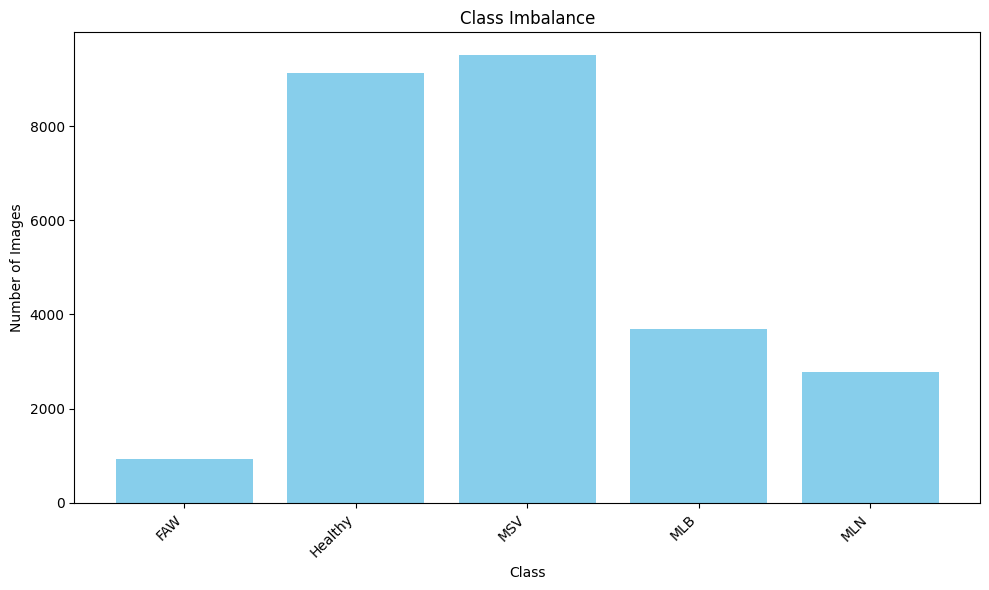

In [ ]:
#Check for class imbalance

import os
import matplotlib.pyplot as plt

def plot_class_imbalance(data_dir):
    """
    Plot class imbalance based on the number of images in each class.

    Args:
    - data_dir (str): Path to the directory containing subdirectories for each class.

    Returns:
    - None
    """
    # Get the list of class directories
    class_directories = [d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))]

    # Initialize lists to store class names and number of images
    class_names = []
    num_images = []

    # Iterate through each class directory
    for class_dir in class_directories:
        # Count the number of images in the class directory
        class_images = len(os.listdir(os.path.join(data_dir, class_dir)))
        # Append class name and number of images to lists
        class_names.append(class_dir)
        num_images.append(class_images)

    # Plot the class imbalance
    plt.figure(figsize=(10, 6))
    plt.bar(class_names, num_images, color='skyblue')
    plt.xlabel('Class')
    plt.ylabel('Number of Images')
    plt.title('Class Imbalance')
    plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better visibility
    plt.tight_layout()  # Adjust layout to prevent overlapping labels
    plt.show()

# Example usage:
plot_class_imbalance(train_dir)


In [ ]:
# Setup data inputs
import tensorflow as tf
IMG_SIZE = (448, 448)
train_data = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                 label_mode="categorical",
                                                                 image_size=IMG_SIZE)

valid_data = tf.keras.preprocessing.image_dataset_from_directory(valid_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE,
                                                                shuffle=False) # don't shuffle test data for prediction analysis


Found 26063 files belonging to 5 classes.
Found 7445 files belonging to 5 classes.


# **MODEL**

Now that the data is ready to be fed to the model. The question is which is the best model to use!. Three different experiments were run using 10% of the data to select the model that gives the best performance . These included;


1.   EfficientNetB0
2.   ResnetV250
3.   VGG19

Ultimately EfficientNetBO was chosen because of two reasons ;


1.   Higher Accuracy
2.   Small size (Almost 5x smaller than ResnetV250 and almost 10x smaller than VGG19) for deployment in a Mobile App which is one of the objectives of this Hackathon

This section has two parts.Firstly training a feature extraction model (EffiientnetB0) and secondly fine-tuning the model. Due to colabs limits, these parts were done sequentially but separately. Ie. Use first 3hrs limit for the first part --> Save model --> Load saved model and use it for second part(Another 3hr Limit)

## **EFFICIENTNETB0**

Here, a pretrained transfer learning model trained on imagenet was used. Efficientnet performed very well on imagenet with fewer parameters. More information can be found on https://arxiv.org/pdf/1905.11946



Only the top layer was removed and replaced with a dense layer with softmax activation. Before we get started with the modelling we need to set up 4 things;



**Mixed Precision Training:** Increases training speed and reduces memory usage by using lower precision (float16) while maintaining model accuracy with selective higher precision (float32).This works very well with GPUs with compute capability 7.0 or higher such as T4

**Tensorboard Callback:** Enables real-time visualization of metrics, training progress, and model graphs within TensorBoard, aiding in debugging and optimization.

**Early Stopping Callback**: Halts training when the monitored metric (e.g., validation loss) stops improving after a specified number of epochs, preventing overfitting and saving resources.

**ReduceLROnPlateau Callback**: Reduces the learning rate when the monitored metric (e.g., validation loss) stops improving, helping the model to converge more effectively.

In [ ]:
# Turn on mixed precision training
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy(policy="mixed_float16") # set global policy to mixed precision

In [ ]:
mixed_precision.global_policy() # should output "mixed_float16" (if your GPU is compatible with mixed precision)

<Policy "mixed_float16">

In [ ]:
from helper_functions import create_tensorboard_callback

# Create checkpoint callback to save model for later use
checkpoint_path_1 = "100_percent_efficientnet_model_checkpoint"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path_1,
                                                         save_weights_only=True, # save only the model weights
                                                         monitor="val_loss", # save the model weights which score the best validation accuracy
                                                         save_best_only=True) # only keep the best model weights on file (delete the rest)



# Setup EarlyStopping callback to stop training if model's val_loss doesn't improve for 3 epochs
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", # watch the val loss metric
                                                  patience=5) # if val loss decreases for 5 epochs in a row, stop training

# Creating learning rate reduction callback
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",
                                                 factor=0.2, # multiply the learning rate by 0.2 (reduce by 5x)
                                                 patience=3,
                                                 verbose=1, # print out when learning rate goes down
                                                 min_lr=1e-8)


In [ ]:
# Import the required modules for model creation
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers.experimental import preprocessing
from helper_functions import plot_loss_curves

# ## NEW: Newer versions of TensorFlow (2.10+) can use the tensorflow.keras.layers API directly for data augmentation
# data_augmentation = Sequential([
#   layers.RandomFlip("horizontal"),
#   layers.RandomRotation(0.2),
#   #layers.RandomZoom(0.2),
#   layers.RandomHeight(0.2),
#   layers.RandomWidth(0.2),
#   # preprocessing.Rescaling(1./255) # keep for ResNet50V2, remove for EfficientNetB0
# ], name ="data_augmentation")


In [ ]:
# Setup base model and freeze its layers (this will extract features)
base_model_1 = tf.keras.applications.efficientnet.EfficientNetB0(include_top=False)
base_model_1.trainable = False

# Setup model architecture with trainable top layers
inputs = layers.Input(shape=(448, 448, 3), name="input_layer") # shape of input image
# x = data_augmentation(inputs) # augment images (only happens during training)
x = base_model_1(inputs, training=False) # put the base model in inference mode so we can use it to extract features without updating the weights
x = layers.GlobalAveragePooling2D(name="global_average_pooling")(x) # pool the outputs of the base model
x = layers.Dropout(0.2)(x)
x = layers.Dense(5)(x) # want one output neuron per class
# Separate activation of output layer so we can output float32 activations
outputs = layers.Activation("softmax", dtype=tf.float32, name="softmax_float32")(x)
model_efficientnet = tf.keras.Model(inputs, outputs)

16705208/16705208 [==============================] - 0s 0us/step


In [ ]:
# Get a summary of our model
model_efficientnet.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 448, 448, 3)]     0         
                                                                 
 efficientnetb0 (Functional  (None, None, None, 1280   4049571   
 )                           )                                   
                                                                 
 global_average_pooling (Gl  (None, 1280)              0         
 obalAveragePooling2D)                                           
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 5)                 6405      
                                                                 
 softmax_float32 (Activatio  (None, 5)                 0     

In [ ]:
# Compile
model_efficientnet.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(), # use Adam with default settings
              metrics=["accuracy"])



In [ ]:
# Turn off all warnings except for errors
tf.get_logger().setLevel('ERROR')

# Fit
tf.random.set_seed(42)


history_efficientnet = model_efficientnet.fit(train_data,
                                  epochs=30, # fit for 30 epochs to keep experiments quick
                                  steps_per_epoch=len(train_data),
                                  validation_data=valid_data,
                                  validation_steps=int(len(valid_data)),
                                  callbacks=[create_tensorboard_callback("training_logs", "efficientnet_feature_extraction"), # track the model training logs
                                                  checkpoint_callback, # save only the best model during training
                                                  early_stopping, # stop model after X epochs of no improvements
                                                  reduce_lr]) # reduce the learning rate after X epochs of no improvements


Saving TensorBoard log files to: training_logs/efficientnet_feature_extraction/20240517-134942
Epoch 1/10
815/815 [==============================] - 515s 610ms/step - loss: 0.2494 - accuracy: 0.9286 - val_loss: 0.1212 - val_accuracy: 0.9666 - lr: 0.0010
Epoch 2/10
815/815 [==============================] - 449s 547ms/step - loss: 0.1092 - accuracy: 0.9667 - val_loss: 0.0955 - val_accuracy: 0.9719 - lr: 0.0010
Epoch 3/10
815/815 [==============================] - 451s 550ms/step - loss: 0.0901 - accuracy: 0.9719 - val_loss: 0.0791 - val_accuracy: 0.9766 - lr: 0.0010
Epoch 4/10
815/815 [==============================] - 453s 552ms/step - loss: 0.0790 - accuracy: 0.9744 - val_loss: 0.0763 - val_accuracy: 0.9772 - lr: 0.0010
Epoch 5/10
815/815 [==============================] - 456s 556ms/step - loss: 0.0727 - accuracy: 0.9773 - val_loss: 0.0707 - val_accuracy: 0.9770 - lr: 0.0010
Epoch 6/10
815/815 [==============================] - 458s 558ms/step - loss: 0.0674 - accuracy: 0.9782 - val_

In [ ]:
# Define paths for saving and loading the model
model_save_path = "/content/efficientnet_model_expt_b0noaug.h5"

# Save the model
model_efficientnet.save(model_save_path)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


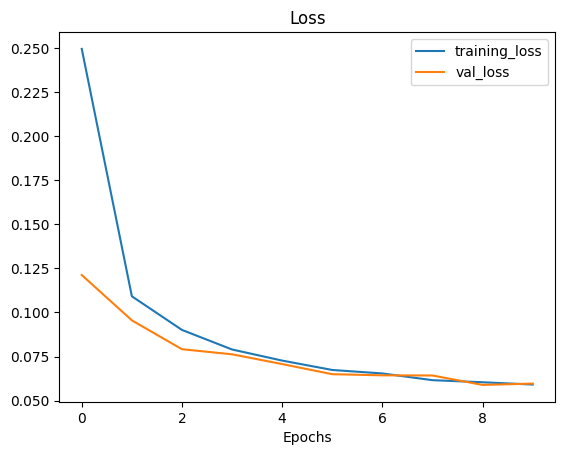

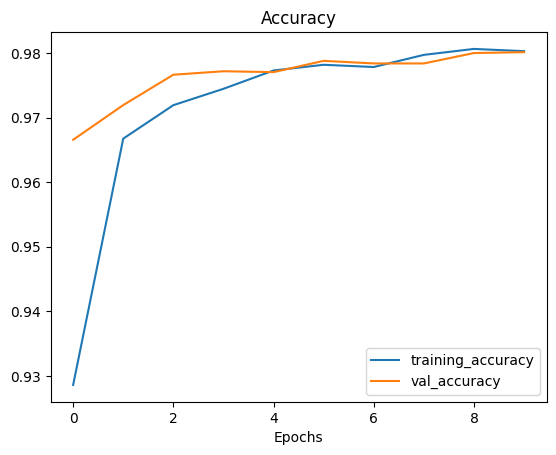

In [ ]:
plot_loss_curves(history_efficientnet)

## **FINE-TUNING THE EFFICIENTNETB0 MODEL**
During fine-tuning, a number of top layers are unfrozen and trained on the custom dataset

Time to finetune the model!. Due to Serial Experimentation (over 25 experiments) and Research, the following model and dataset parameter values are the best proven values that yielded the best results. These parameters are used across the entire notebook.


**Parameter : Value**
*   Dropout : 0.2
*   Image size : 448,448
*   Batch size : 32
*   Number of layers finetuned : 118
*   Augmentation layers : None (Basically no augmentation was done)
*   Patience value for early stopping callback : 5
*   Patience value for ReduceLROnPlateau callback : 3




















In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dropout, Dense, Activation
from tensorflow.keras.models import load_model
from helper_functions import plot_loss_curves

In [ ]:
# Load the model architecture from the saved .h5 file
model_efficientnet = tf.keras.models.load_model('/content/efficientnet_model_expt_b0noaug.h5')

# Unfreeze all of the layers in the base model
base_model_1 = model_efficientnet.layers[1]

base_model_1.trainable = True

# First, freeze all layers in the base model
for layer in base_model_1.layers:
    layer.trainable = False

# Then, unfreeze the top 118 layers while leaving BatchNorm layers frozen
for layer in base_model_1.layers[-118:]:
    if not isinstance(layer, layers.BatchNormalization):
        layer.trainable = True


In [ ]:
# Recompile model with lower learning rate
model_efficientnet.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(1e-4), # 10x lower learning rate than default
              metrics=['accuracy'])


In [ ]:

# What layers in the model are trainable?
for layer in model_efficientnet.layers:
  print(layer.name, layer.trainable)

input_layer True
efficientnetb0 True
global_average_pooling True
dropout True
dense True
softmax_float32 True


In [ ]:
# Check which layers are trainable
for layer_number, layer in enumerate(base_model_1.layers):
  print(layer_number, layer.name, layer.trainable)

0 input_1 False
1 rescaling False
2 normalization False
3 rescaling_1 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeeze False
39

In [ ]:
tf.random.set_seed(42)

fine_tune_epochs = 25

history_efficientnet_fine_tuned = model_efficientnet.fit(train_data,
                                             epochs=fine_tune_epochs,
                                             steps_per_epoch=len(train_data),
                                             validation_data=valid_data,
                                             validation_steps=int(len(valid_data)),
                                             callbacks=[create_tensorboard_callback("training_logs", "efficientnet_fine_tuning"), # track the model training logs
                                                        checkpoint_callback, # save only the best model during training
                                                        early_stopping, # stop model after X epochs of no improvements
                                                        reduce_lr]) # reduce the learning rate after X epochs of no improvements

Saving TensorBoard log files to: training_logs/efficientnet_fine_tuning/20240524-183303
Epoch 1/25
815/815 [==============================] - 458s 528ms/step - loss: 0.0431 - accuracy: 0.9864 - val_loss: 0.0320 - val_accuracy: 0.9915 - lr: 1.0000e-04
Epoch 2/25
815/815 [==============================] - 426s 518ms/step - loss: 0.0201 - accuracy: 0.9938 - val_loss: 0.0346 - val_accuracy: 0.9882 - lr: 1.0000e-04
Epoch 3/25
815/815 [==============================] - 427s 520ms/step - loss: 0.0116 - accuracy: 0.9971 - val_loss: 0.0231 - val_accuracy: 0.9944 - lr: 1.0000e-04
Epoch 4/25
815/815 [==============================] - 426s 518ms/step - loss: 0.0105 - accuracy: 0.9974 - val_loss: 0.0225 - val_accuracy: 0.9946 - lr: 1.0000e-04
Epoch 5/25
815/815 [==============================] - 426s 519ms/step - loss: 0.0091 - accuracy: 0.9974 - val_loss: 0.0393 - val_accuracy: 0.9910 - lr: 1.0000e-04
Epoch 6/25
815/815 [==============================] - 432s 525ms/step - loss: 0.0082 - accuracy: 

In [ ]:
# Save the model
model_efficientnet.save("/content/efficientnet_model_expt_b0noaugft.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


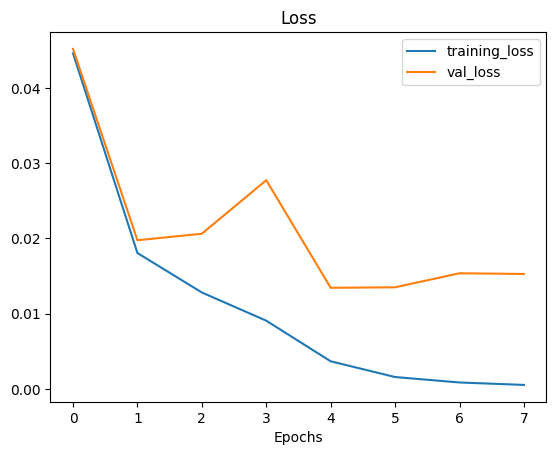

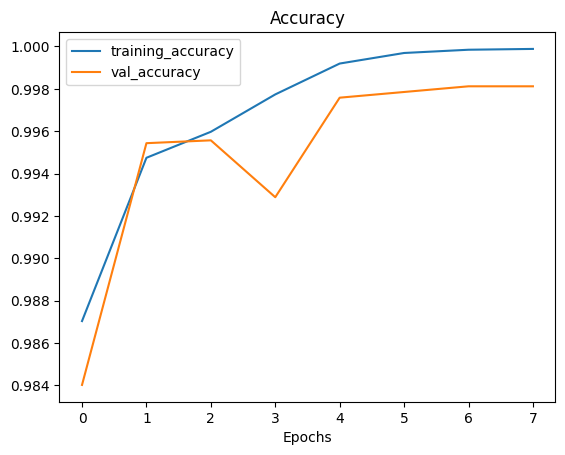

In [ ]:
plot_loss_curves(history_efficientnet_fine_tuned)

# **SUBMISSION**

The finetuned model that was saved above is now loaded to be used for submission. At the end of this notebook the csv file was downloaded and uploaded to the leaderboard

**NB 1:** There was one issue encountered with the test data . Particularly with image 492 having a colour error being labelled as corrupted and errored out the code for submission. Therefore the image was manually cropped to remove the colour error. Therefore when running this notebook , The test set was downloaded (about 1.85gb) --> Image 492 corrected --> The dataset uploaded to a google drive and the link copied.

**NB:2:** The predictions made in this part of the code were rounded off to 4dp as was shown in an image that was used in the "making a submission" notebook provided under the Hackathon Github repository. As a team we feel that better f1 scores might have been obtained had the rounding been to like 2dp . However we have to adhere to the stict guidelines.

In [ ]:
from tensorflow.keras.models import load_model


# Load the model
loaded_model = load_model("/content/efficientnet_model_expt_b0noaugft.h5")

In [ ]:
loaded_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 448, 448, 3)]     0         
                                                                 
 efficientnetb0 (Functional  (None, None, None, 1280   4049571   
 )                           )                                   
                                                                 
 global_average_pooling (Gl  (None, 1280)              0         
 obalAveragePooling2D)                                           
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 5)                 6405      
                                                                 
 softmax_float32 (Activatio  (None, 5)                 0     

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from helper_functions import walk_through_dir

# How many images/classes are in training set?
test_dir = "/content/drive/MyDrive/test"
walk_through_dir(test_dir)

There are 0 directories and 3728 images in '/content/drive/MyDrive/test'.


In [ ]:
import os
import pandas as pd
import tensorflow as tf
# Define the directory containing test images

IMG_SIZE = (448,448)

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode=None,
                                                                batch_size = 32,
                                                                image_size=IMG_SIZE,
                                                                shuffle=False) # don't shuffle test data for prediction analysis


Found 3728 files belonging to 1 classes.


In [ ]:
import os
import pandas as pd


# Write a function to process an image and return the probabilities.
def make_predictions(img_path):
    try:
        img = tf.keras.utils.load_img(img_path, target_size=(448, 448))
        img_arr = tf.keras.utils.img_to_array(img)
        img_arr = tf.expand_dims(img_arr, 0) # Create a batch
        predictions = loaded_model.predict(img_arr)
        scores = [s.round(4) for s in predictions[0]]
        return [os.path.basename(img_path), *scores]
    except Exception as e:
        print(f"Error processing image {img_path}: {e}")
        return None

# Create a dataframe
results_cols = ["filename", "faw", "healthy", "mlb", "mln", "msv"]
results = []

# Loop through all test images and make a prediction
for filename in os.listdir(test_dir):
    if filename.endswith(".jpg"):  # Ensure only JPEG images are processed
        img_path = os.path.join(test_dir, filename)
        pred = make_predictions(img_path)
        if pred is not None:
            results.append(pred)

# Create a DataFrame using the results list
df = pd.DataFrame(results, columns=results_cols)
# Display the first few rows of the DataFrame
df.head()


1/1 [==============================] - 0s 26ms/step


,filename,faw,healthy,mlb,mln,msv
0,test_1192.jpg,0.0,0.0,0.0,0.0,1.0
1,test_3094.jpg,0.0,0.0,0.0,0.0,1.0
2,test_517.jpg,0.0,0.0,0.0,0.0,1.0
3,test_1244.jpg,0.0,0.0,0.0,0.0,1.0
4,test_2276.jpg,0.0,0.0,0.0,0.0,1.0


In [ ]:
df

,filename,faw,healthy,mlb,mln,msv
0,test_1192.jpg,0.0,0.0,0.0,0.0,1.0
1,test_3094.jpg,0.0,0.0,0.0,0.0,1.0
2,test_517.jpg,0.0,0.0,0.0,0.0,1.0
3,test_1244.jpg,0.0,0.0,0.0,0.0,1.0
4,test_2276.jpg,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...
3723,test_3523.jpg,0.0,0.0,0.0,1.0,0.0
3724,test_2200.jpg,0.0,0.0,0.0,1.0,0.0
3725,test_2546.jpg,0.0,0.0,0.0,1.0,0.0
3726,test_824.jpg,0.0,0.0,0.0,1.0,0.0


In [ ]:
# Write to a csv
# Note that the csv must be named according to the team name
team_name= 'ENIAC'
df.to_csv(f'{team_name}.csv', index=False)


# **WHAT TO DO NEXT**

The following are the potential next steps for this notebook;



1. **Finding ways to work around the issue of class imbalance**. Smote and Upsampling were experimented however, attempts were futile as the ram kept crashing.  
2. **Creating a more efficient data pipeline**. This will improve dataset loading and model training speeds. As well as possibly answering the challenge in 1 above.






In [1]:
!pip freeze > requirements.txt